mynavi scraping

In [1]:
#必要なライブラリを読み込む
from urllib.request import urlopen
from bs4 import BeautifulSoup
import requests
import time
import re

import numpy as  np
import pandas as pd
from matplotlib import pyplot as plt
import japanize_matplotlib #日本語化するライブラリ

In [13]:
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
# 1．検索条件（場所、業種未経験）を設定する
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

#*** 検索したい条件以外をコメントアウト（Windows：Ctrl + /）***
# where = "kansai"; pa = "/list/pa1/"; paa = "pa1" #関西x業種未経験
# where = "shutoken"; pa = "/list/pa1/"; paa = "pa1" #首都圏x業種未経験
# where = "kansai"; pa = "/list/"; paa = "all" #関西x経験者（特定の検索条件なし）
where = "shutoken"; pa = "/list/"; paa = "all" #首都圏x経験者（特定の検索条件なし）

In [14]:
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
# 2．HTML形式で全ページ保存する
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

#＝＝＝総ページ数を取得＝＝＝
url = f'https://tenshoku.mynavi.jp/{where}{pa}kwpython/only/' #URL *Where,paは検索条件から置換
print(url) #de
html = urlopen(url)
soup = BeautifulSoup(html)
ttl_num = soup.find(class_ = "total_txt total_num") #1ページ目から総案件数を取得
ttl_num = int(ttl_num.text.replace(",","")) #4桁以上で表示される「,」を取り除く ex.)3,400 => 3400
print("総案件数=", ttl_num) #総案件数を表示
ttl_page = ttl_num // 50 + 1 #総案件数から総ページ数を計算 1ページ最大50件
print("総ページ数=", ttl_page) #総ページ数を表示

#＝＝＝各ページをHTML形式で保存＝＝＝
page_range = range(1, ttl_page+1) #保存するページ範囲を指定
for page in page_range: #1ページごとに処理
    site_data = requests.get(f'https://tenshoku.mynavi.jp/{where}{pa}kwpython/only/pg{page}/') #requestsでgetをリクエスト *Where,pa,pageは検索条件から置換
    with open(f"{where}_{paa}_{page}.html", "w") as f: #保存名と形式を指定 *Where,pa,pageは検索条件から置換
        f.write(site_data.text) #保存
    time.sleep(3) #サーバー負荷低減のために次ページに移る前に3秒待つ
print("書き込みが完了しました") #処理完了メッセージ

https://tenshoku.mynavi.jp/shutoken/list/kwpython/only/
総案件数= 2582
総ページ数= 52
書き込みが完了しました


In [15]:
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
# 3．保存したHTMLファイルを開き、年収と会社名を取得、DataFrameに格納する
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

#リスト初期化
cname_lst = [] #会社名リスト
salary_lst = [] #年収リスト

for page in page_range: #1ページごとに処理
    html = f"{where}_{paa}_{page}.html" #HTML *Where,pa,pageは検索条件から置換
    print(html,"読み込み") #de

    with open(html, 'r') as f: #HTMLを開く
        soup = BeautifulSoup(f.read(), 'html.parser')
    tables = soup.find_all("table", {"class": "detaile_table"}) #detaile_tableクラスのテーブルをすべて取得

    #＝＝＝年収＝＝＝
    for table in tables: #tableごとに処理
        rows = table.find_all("tr") #trタグをすべて取得
        second_tr = rows[1]  # 2つ目のtr（給与）を取得
        csvRow = [] #空のリストを準備
        for cell in second_tr.find_all(["th", "td"]): #celごとに処理 thとtdをすべて取得
            csvRow.append(cell.get_text().strip()) #テキストのみ取得、両端（先頭、末尾）の文字を削除してリストに格納
        # print(csvRow[1]) #de 給与情報を表示
        salary = csvRow[1] #salaryに給与情報のみ格納、cscRowはリスト型（[0]は「給与」 [1]は給与情報）
        match = re.search(r'(?:年収:|年収|年収 |【年収】|<想定年収> |初年度の年収：)(?!,)(\d{3})', salary) #salaryの文字列から数字3桁を抽出、「|」でand検索
        if match is not None: #抽出した数字を出力する
            salary = int(match.group(1)) #正規表現のパターンに最初に一致するもののみ返す
            # print(salary) #de 給与額を表示
            salary_lst.append(salary) #salary_lstに給与額のみ格納（リスト型）
            #＝＝＝年収があるものだけ会社名を抽出する＝＝＝
            company = table.parent.parent.parent.parent #tableの4つ親階層まで遡る
            names = company.find("p", {"class": "main_title"}) #companyからpタグのmain_titleクラスを取得
            for name in names: #nameごとに処理
                cname = name.text.split("|")[0] #会社名のみを抽出 「|」で区切った1つ目が会社名
                # print(cname)#de 会社名を表示
                cname_lst.append(cname) #cname_lstに会社名のみを格納（リスト型）
        else: #正規表現のパターンに一致するテキストがない場合
            pass #何もしない
            # print('見つかりませんでした。') #de

print("有効給与数=", len(salary_lst)) #有効給与数を表示
print("有効会社数=", len(cname_lst)) #有効会社数を表示

exec(f"{where}_{paa}_df = pd.DataFrame({{'会社名': cname_lst, '年収': salary_lst}})") #動的に名前を付けてDataFrameに格納 *Where,pa,pageは検索条件から置換
print(f"{where}_{paa}_df") #DataFrame名を表示

shutoken_all_1.html 読み込み
shutoken_all_2.html 読み込み
shutoken_all_3.html 読み込み
shutoken_all_4.html 読み込み
shutoken_all_5.html 読み込み
shutoken_all_6.html 読み込み
shutoken_all_7.html 読み込み
shutoken_all_8.html 読み込み
shutoken_all_9.html 読み込み
shutoken_all_10.html 読み込み
shutoken_all_11.html 読み込み
shutoken_all_12.html 読み込み
shutoken_all_13.html 読み込み
shutoken_all_14.html 読み込み
shutoken_all_15.html 読み込み
shutoken_all_16.html 読み込み
shutoken_all_17.html 読み込み
shutoken_all_18.html 読み込み
shutoken_all_19.html 読み込み
shutoken_all_20.html 読み込み
shutoken_all_21.html 読み込み
shutoken_all_22.html 読み込み
shutoken_all_23.html 読み込み
shutoken_all_24.html 読み込み
shutoken_all_25.html 読み込み
shutoken_all_26.html 読み込み
shutoken_all_27.html 読み込み
shutoken_all_28.html 読み込み
shutoken_all_29.html 読み込み
shutoken_all_30.html 読み込み
shutoken_all_31.html 読み込み
shutoken_all_32.html 読み込み
shutoken_all_33.html 読み込み
shutoken_all_34.html 読み込み
shutoken_all_35.html 読み込み
shutoken_all_36.html 読み込み
shutoken_all_37.html 読み込み
shutoken_all_38.html 読み込み
shutoken_all_39.html 

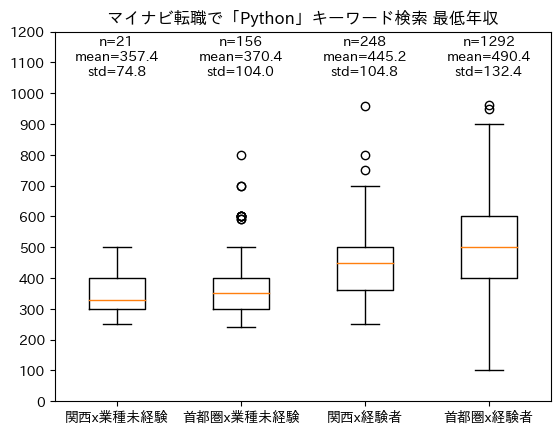

In [16]:
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
# 4．各検索条件ごとのボックスプロットを表示する
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

names = ['関西x業種未経験', '首都圏x業種未経験', '関西x経験者', '首都圏x経験者'] #各項目名
fig = plt.figure() #グラフのサイズを指定
ax = fig.add_subplot(1, 1, 1) #縦並びにグラフを配置
ax.boxplot([kansai_pa1_df.iloc[:, 1], shutoken_pa1_df.iloc[:, 1],kansai_all_df.iloc[:, 1], shutoken_all_df.iloc[:, 1]],labels=names) #複数のデータを横に並べる
plt.title("マイナビ転職で「Python」キーワード検索 最低年収") #タイトル名
plt.yticks(np.arange(0, 1300, 100)) #y軸範囲

#グラフにデータ数、平均値、標準偏差値に表示
data = [kansai_pa1_df.iloc[:, 1], shutoken_pa1_df.iloc[:, 1],kansai_all_df.iloc[:, 1], shutoken_all_df.iloc[:, 1]]
for i, d in enumerate(data):
    n = len(d) #データ数
    mean = round(d.mean(), 1) #平均値 小数点以下1桁
    std = round(d.std(), 1) #標準偏差値 小数点以下1桁
    ax.text(i + 1, 0.99 * ax.get_ylim()[1], f'n={n}\nmean={mean}\nstd={std}', ha='center', va='top') #グラフ中に表示 表示位置など設定
plt.show()

In [17]:
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝
# 確認用
# DataFrameの先頭5行 と 統計量をまとめて表示
#＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

# 首都圏x業種未経験
display(shutoken_pa1_df.head()) 
display(shutoken_pa1_df.describe())

# 首都圏すべて
display(shutoken_all_df.head())
display(shutoken_all_df.describe())

# 関西x業種未経験 
display(kansai_pa1_df.head())
display(kansai_pa1_df.describe())

# 関西すべて 
display(kansai_all_df.head())
display(kansai_all_df.describe())

,会社名,年収
0,株式会社クオーテック,250
1,株式会社マクロセンド,340
2,株式会社アイサット,392
3,エクシオ・デジタルソリューションズ株式会社,400
4,インバウンドテクノロジー株式会社,250


,年収
count,156.000000
mean,370.371795
std,104.003115
min,240.000000
25%,300.000000
50%,350.000000
75%,400.000000
max,800.000000


,会社名,年収
0,株式会社クオーテック,250
1,株式会社マクロセンド,340
2,株式会社アイサット,392
3,エクシオ・デジタルソリューションズ株式会社,400
4,インバウンドテクノロジー株式会社,250


,年収
count,1292.000000
mean,490.380031
std,132.432361
min,100.000000
25%,400.000000
50%,500.000000
75%,600.000000
max,963.000000


,会社名,年収
0,オムロンエキスパートリンク株式会社,370
1,オムロンエキスパートリンク株式会社,370
2,テクニカルシステム株式会社,320
3,株式会社ミップ,350
4,株式会社日本ビジネスデータープロセシングセンター,300


,年収
count,21.000000
mean,357.428571
std,74.796772
min,250.000000
25%,300.000000
50%,329.000000
75%,400.000000
max,500.000000


,会社名,年収
0,Ｓｋｙ株式会社,400
1,株式会社アイビス,400
2,オムロンエキスパートリンク株式会社,370
3,オムロンエキスパートリンク株式会社,370
4,テクニカルシステム株式会社,320


,年収
count,248.000000
mean,445.225806
std,104.750317
min,250.000000
25%,360.000000
50%,450.000000
75%,500.000000
max,960.000000
